In [1]:
"""
Notebook 1: Exploratory Data Analysis (EDA)
Construction Safety Detection
"""
import os
import yaml
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from pathlib import Path


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




# 1. LOAD DATA.YAML

In [3]:
def load_config(yaml_path='/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/data.yaml'):
    """Load konfigurasi dari data.yaml"""
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

config = load_config()
print("Dataset Configuration:")
print(f"Number of classes: {config['nc']}")
print(f"Class names: {config['names']}")
print(f"Train path: {config['train']}")
print(f"Valid path: {config['val']}")
print(f"Test path: {config['test']}")

Dataset Configuration:
Number of classes: 5
Class names: ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']
Train path: ../train/images
Valid path: ../valid/images
Test path: ../test/images



# 2. ANALISIS DISTRIBUSI DATASET

In [4]:

def count_images(image_dir):
    """Hitung jumlah gambar di folder"""
    return len(list(Path(image_dir).glob('*.jpg'))) + len(list(Path(image_dir).glob('*.png')))

def count_labels_per_class(label_dir, num_classes):
    """Hitung jumlah objek per kelas dari file label YOLO"""
    class_counts = Counter()

    for label_file in Path(label_dir).glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

    return class_counts

# Hitung distribusi
train_images = count_images('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/images')
val_images = count_images('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/valid/images')
test_images = count_images('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/test/images')
print("\n" + "="*50)
print("Dataset Distribution:")
print(f"Train images: {train_images}")
print(f"Valid images: {val_images}")
print(f"Test images: {test_images}")
print(f"Total: {train_images + val_images + test_images}")

# Hitung distribusi kelas
train_class_counts = count_labels_per_class('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/labels', config['nc'])
val_class_counts = count_labels_per_class('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/valid/labels', config['nc'])

print("\n" + "="*50)
print("Class Distribution in Training Set:")
for class_id, count in sorted(train_class_counts.items()):
    print(f"  {config['names'][class_id]}: {count}")



Dataset Distribution:
Train images: 997
Valid images: 119
Test images: 90
Total: 1206

Class Distribution in Training Set:
  helmet: 2116
  no-helmet: 94
  no-vest: 741
  person: 2362
  vest: 1073



# 3. VISUALISASI DISTRIBUSI

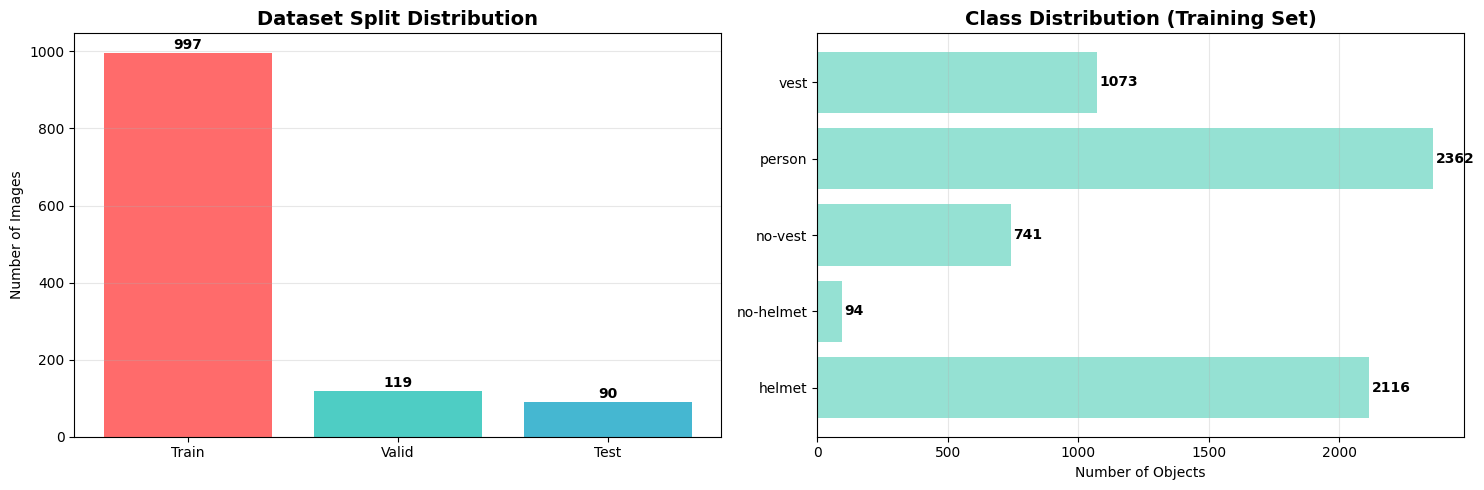

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribusi Dataset Split
splits = ['Train', 'Valid', 'Test']
counts = [train_images, val_images, test_images]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(splits, counts, color=colors)
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Plot 2: Distribusi Kelas
class_names = [config['names'][i] for i in sorted(train_class_counts.keys())]
class_counts_list = [train_class_counts[i] for i in sorted(train_class_counts.keys())]

axes[1].barh(class_names, class_counts_list, color='#95E1D3')
axes[1].set_title('Class Distribution (Training Set)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Objects')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(class_counts_list):
    axes[1].text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()


output_dir = '/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/'
os.makedirs(output_dir, exist_ok=True)

plt.savefig(os.path.join(output_dir, 'eda_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


# 4. VISUALISASI SAMPLE IMAGES WITH ANNOTATIONS

In [6]:

def draw_yolo_boxes(image_path, label_path, class_names):
    """Draw bounding boxes dari format YOLO"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]


    colors = {
        0: (255, 0, 0),      # helmet - red
        1: (255, 165, 0),    # no-helmet - orange
        2: (255, 255, 0),    # no-vest - yellow
        3: (0, 255, 0),      # person - green
        4: (0, 0, 255)       # vest - blue
    }

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])

                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width/2) * w)
                y1 = int((y_center - height/2) * h)
                x2 = int((x_center + width/2) * w)
                y2 = int((y_center + height/2) * h)

                # Draw box
                color = colors.get(class_id, (255, 255, 255))
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                # Draw label
                label = class_names[class_id]
                cv2.putText(img, label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

# Visualisasi 6 sample gambar
train_images_list = list(Path('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/images').glob('*.jpg'))[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, img_path in enumerate(train_images_list):
    label_path = str(img_path).replace('images', 'labels').replace('.jpg', '.txt')

    img_with_boxes = draw_yolo_boxes(str(img_path), label_path, config['names'])

    axes[idx].imshow(img_with_boxes)
    axes[idx].set_title(f'Sample {idx+1}: {img_path.name}', fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/sample_images_annotated.png', dpi=300, bbox_inches='tight')
plt.show()


Output hidden; open in https://colab.research.google.com to view.


# 5. ANALISIS OBJECTS PER IMAGE


Objects per Image Statistics (Training Set):
  Mean: 6.41
  Median: 6.00
  Min: 1
  Max: 39


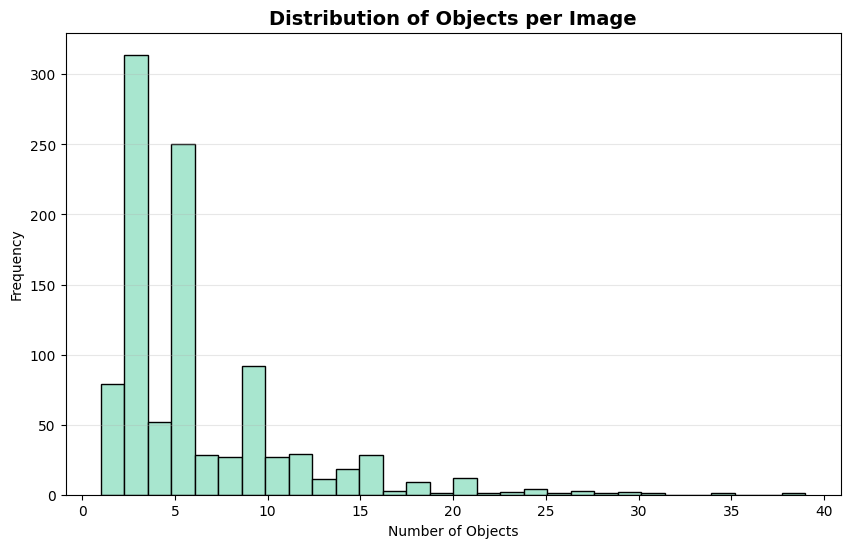


✅ EDA Completed! Check the 'results' folder for visualizations.


In [7]:
def count_objects_per_image(label_dir):
    """Hitung rata-rata objek per gambar"""
    object_counts = []

    for label_file in Path(label_dir).glob('*.txt'):
        with open(label_file, 'r') as f:
            object_counts.append(len(f.readlines()))

    return object_counts

train_obj_counts = count_objects_per_image('/content/drive/MyDrive/Colab Notebooks/Capstone 4/extracted/train/labels')

print("\n" + "="*50)
print("Objects per Image Statistics (Training Set):")
if train_obj_counts:
    print(f"  Mean: {np.mean(train_obj_counts):.2f}")
    print(f"  Median: {np.median(train_obj_counts):.2f}")
    print(f"  Min: {np.min(train_obj_counts)}")
    print(f"  Max: {np.max(train_obj_counts)}")
else:
    print("  No objects found in the training labels directory.")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_obj_counts, bins=30, color='#A8E6CF', edgecolor='black')
plt.title('Distribution of Objects per Image', fontsize=14, fontweight='bold')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Capstone 4/results/objects_per_image_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ EDA Completed! Check the 'results' folder for visualizations.")